In [60]:
from matplotlib import pyplot as plt
from kats.consts import TimeSeriesData
import pandas as pd
from utils import save_fig_for_raport, dataframe_to_latex_tabular 
from pandas.plotting import autocorrelation_plot
import pandas.plotting
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from kats.utils.decomposition import TimeSeriesDecomposition
from kats.detectors.seasonality import FFTDetector
from kats.detectors.outlier import OutlierDetector

In [34]:
raw_data = pd.read_csv('../datasets/raw/market_insights_overview_5p_full.csv', parse_dates=["date"])

# Filter away early 2018 data as it seems to contain errors
raw_data =raw_data .loc[raw_data ['date'] > '2018-12-01']

,hits,date
1852,7,2021-09-08
1853,7,2021-09-07
1854,13,2021-09-06
1855,1,2021-09-05
1856,3,2021-09-04
...,...,...
2246,27,2020-04-04
2247,26,2020-04-03
2248,30,2020-04-02
2249,22,2020-04-01


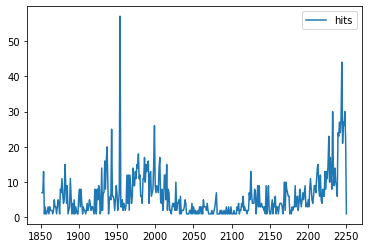

In [46]:
raw_data.loc[raw_data["cat_id"] == 11037][["hits"]].plot()
raw_data.loc[raw_data["cat_id"] == 11037][["hits", "date"]]

In [3]:
categories = pd.read_csv("../datasets/raw/solr_categories_all_2022_02_14.csv")
# Join market_insight table with category names
category_names = categories[[ "internal_doc_id", "title"]]
category_id_to_names_map = dict(map(lambda x: (x["internal_doc_id"], x["title"]), category_names.to_dict("records")))
category_name_to_id_map = dict(map(lambda x: (x["title"], x["internal_doc_id"]), category_names.to_dict("records")))

In [51]:

data_grouped = raw_data.groupby(['cat_id', "date"], as_index=False).sum()
data_grouped["date"] = pd.to_datetime(data_grouped["date"])
data_grouped["interest"] = data_grouped["hits"] + data_grouped["clicks"]

# Join with category names
data_grouped = pd.merge(data_grouped , category_names, how="left", left_on=["cat_id"], right_on=["internal_doc_id"])
data_grouped.rename(columns={"title": "cat_name"}, inplace=True)
data_grouped.drop(columns=["internal_doc_id"], inplace=True, axis=1)

data_chosen_categories = data_grouped[["interest", "date", "cat_id", "cat_name"]]
data = data_chosen_categories

<AxesSubplot:>

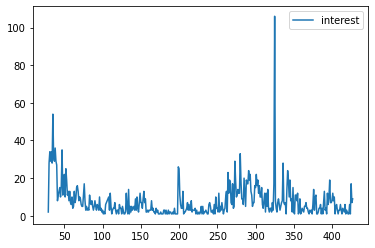

In [49]:
data.loc[data["cat_id"] == 11037][["interest"]].plot()

In [5]:
# Fill in all missing days
#data_grouped_filled_dates = data_chosen_categories.groupby(pd.Grouper(key="date", freq='D')).sum()

#data = data_grouped_filled_dates
#data.head()

In [29]:
# Pivot table by cat_id
data_by_cat_id = data.pivot(index=["date"], columns=["cat_id", "cat_name"])["interest"]
data_by_cat_id.head()

cat_id,33,11037,11091,11573
cat_name,Tastatur,Grill,3D-printer,Nettverkskabler
date,,,,
2018-12-02,NaN,NaN,2.0,2.0
2018-12-03,NaN,NaN,2.0,4.0
2018-12-04,NaN,NaN,2.0,2.0
2018-12-05,NaN,NaN,NaN,4.0
2018-12-06,NaN,NaN,NaN,4.0


In [6]:
corr_categories = [2, 6, 9, 10, 11, 13, 20]

seasonal_categories_cat_name =["Vinterjakke",
"Vintersko",
"Langrennski",
"Skisko",
"Varmeovn",
"Snøfreser",
"Snøskuffe",]

seasonal_categories = list(map(lambda x: category_name_to_id_map[x], seasonal_categories_cat_name))
seasonal_categories

[12322, 11428, 11850, 11852, 273, 11036, 11213]

## Decompose time series
We can decompose each series in into its trend, seasonality and residuals (rest).
Then we can use the dicky-fuller test on the residuals to check if the series is stationary.
If the p-value is < 0.05 it is stationary.
Results: The risiduals are mostly stationary

In [54]:
nettverkskabler = data_grouped.loc[data["cat_id"] ==  11037]
#nettverkskabler['date'] =  pd.to_datetime(raw_data['date'])
nettverkskabler = nettverkskabler.rename(columns={"date": "time"})
ts = TimeSeriesData(nettverkskabler[["time", "interest"]])

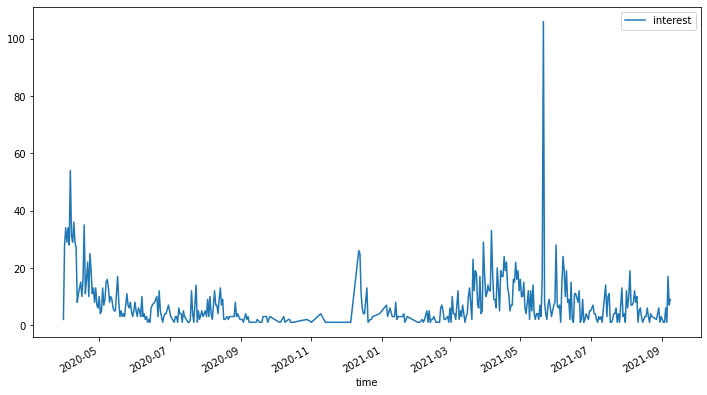

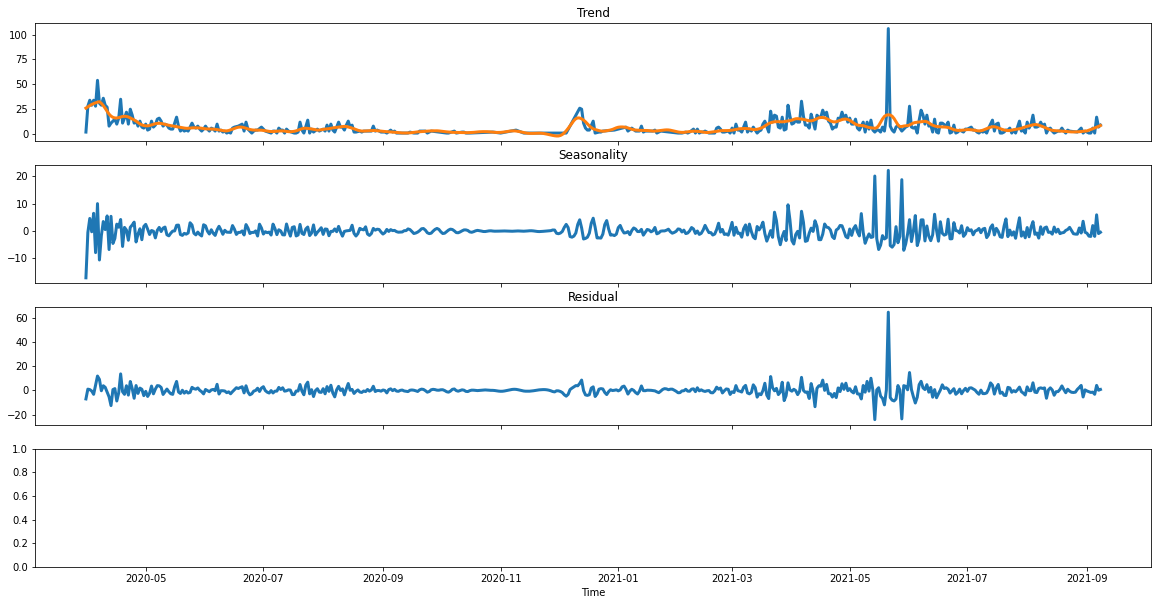

In [56]:
ts.plot()
decomposer = TimeSeriesDecomposition(ts, decomposition="additive")
results = decomposer.decomposer()
fig = decomposer.plot()

In [58]:
# Detect seasonality
fft_detector = FFTDetector(ts)
fft_detector.detector()

{'seasonality_presence': True, 'seasonalities': [133.0]}

In [61]:
outlier_detector = OutlierDetector(ts, "additive")

outlier_detector.detector()
outliers = outlier_detector.outliers
outliers[0]

[Timestamp('2020-03-31 00:00:00'),
 Timestamp('2020-04-06 00:00:00'),
 Timestamp('2020-04-12 00:00:00'),
 Timestamp('2020-04-18 00:00:00'),
 Timestamp('2021-03-21 00:00:00'),
 Timestamp('2021-03-30 00:00:00'),
 Timestamp('2021-04-06 00:00:00'),
 Timestamp('2021-05-18 00:00:00'),
 Timestamp('2021-05-19 00:00:00'),
 Timestamp('2021-05-21 00:00:00'),
 Timestamp('2021-05-22 00:00:00'),
 Timestamp('2021-05-23 00:00:00'),
 Timestamp('2021-05-24 00:00:00'),
 Timestamp('2021-06-01 00:00:00'),
 Timestamp('2021-06-07 00:00:00'),
 Timestamp('2021-09-06 00:00:00')]

<AxesSubplot:xlabel='time'>

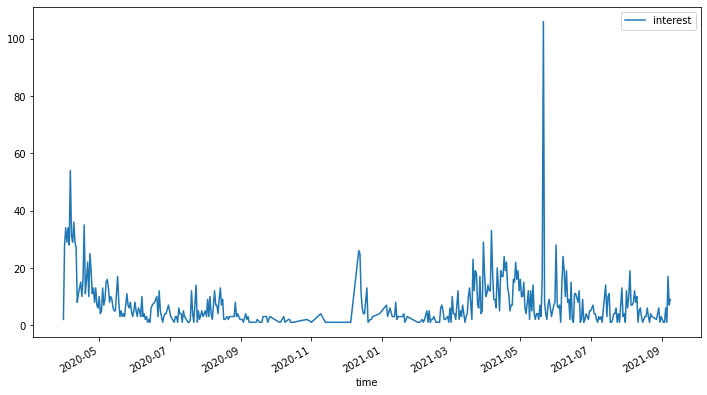

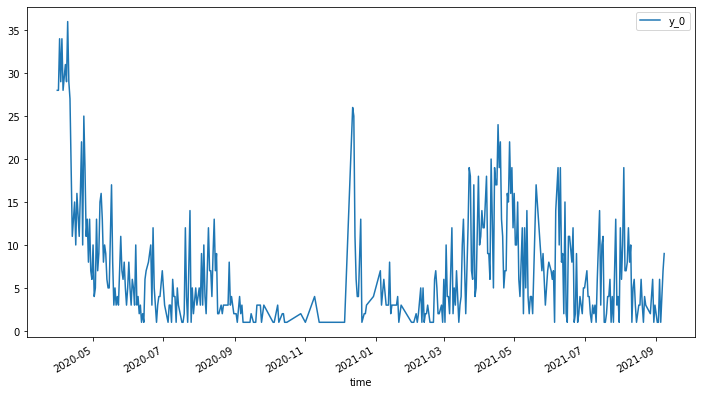

In [63]:
ts_outliers_interpolated = outlier_detector.remover(interpolate=True)
ts.plot()
ts_outliers_interpolated.plot()

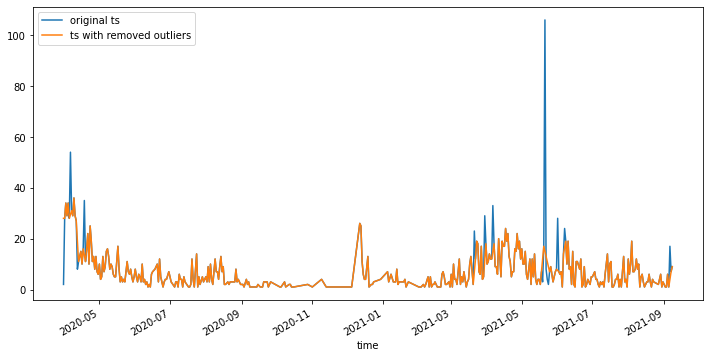

In [68]:
ax = ts.to_dataframe().plot(x="time", y="interest", figsize=(12, 6))
ts_outliers_interpolated.to_dataframe().plot(x="time", y="y_0", ax=ax)
plt.legend(labels=["original ts", "ts with removed outliers"])
plt.show()